In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 3-2 Fulham - Premier League 2025_2026 Live.html"
fotmob_matchId = 4813610

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [4]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [5]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [6]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [7]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [8]:
df = df.merge(dfp, on='playerId', how='left')

In [9]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'relatedEventId',
       'relatedPlayerId', 'blockedX', 'blockedY', 'isGoal', 'cardType',
       'teamName', 'oppositionTeamName', 'shirtNo', 'name', 'position',
       'isFirstEleven', 'shortName'],
      dtype='object')

In [10]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,blockedY,isGoal,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.895327e+09,3,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Fulham,NaN,NaN,NaN,NaN,NaN
1,2.895327e+09,3,0,0.0,170,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,NaN,NaN,NaN,NaN,NaN
2,2.895327e+09,4,0,0.0,170,60.00,40.00,0,NaN,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,17.0,Alex Iwobi,DMC,True,A. Iwobi
3,2.895327e+09,5,0,4.0,170,42.12,38.56,0,NaN,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,5.0,Joachim Andersen,DC,True,J. Andersen
4,2.895327e+09,4,0,5.0,32,27.60,23.12,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Fulham,18.0,Casemiro,DMC,True,Casemiro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,2.895460e+09,920,101,50.0,170,0.00,0.00,105,NaN,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,NaN,NaN,NaN,NaN,NaN
1595,2.895460e+09,789,0,0.0,32,0.00,0.00,15,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Fulham,NaN,NaN,NaN,NaN,NaN
1596,2.895460e+09,921,0,0.0,170,0.00,0.00,15,NaN,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,NaN,NaN,NaN,NaN,NaN
1597,2.895267e+09,2,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Fulham,NaN,NaN,NaN,NaN,NaN


In [11]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,402184,31,Senne Lammens,GK,True,S. Lammens
1,353418,2,Diogo Dalot,DR,True,D. Dalot
2,340105,6,Lisandro Martínez,DC,True,L. Martínez
3,99487,5,Harry Maguire,DC,True,H. Maguire
4,118244,23,Luke Shaw,DL,True,L. Shaw
5,88526,18,Casemiro,DMC,True,Casemiro
6,460260,37,Kobbie Mainoo,DMC,True,K. Mainoo
7,386634,16,Amad Diallo,AMR,True,A. Diallo
8,123761,8,Bruno Fernandes,AMC,True,B. Fernandes
9,362758,10,Matheus Cunha,AML,True,M. Cunha


In [12]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna())) | 
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['goalMouthY'].notna()))
]

In [13]:
df=df.reset_index()

In [14]:
df

,index,id,eventId,minute,second,teamId,x,y,expandedMinute,period,...,blockedY,isGoal,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2,2.895327e+09,4,0,0.0,170,60.00,40.00,0,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,17.0,Alex Iwobi,DMC,True,A. Iwobi
1,3,2.895327e+09,5,0,4.0,170,42.12,38.56,0,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,5.0,Joachim Andersen,DC,True,J. Andersen
2,4,2.895327e+09,4,0,5.0,32,27.60,23.12,0,NaN,...,NaN,NaN,NaN,Man Utd,Fulham,18.0,Casemiro,DMC,True,Casemiro
3,5,2.895327e+09,5,0,6.0,32,39.96,25.04,0,NaN,...,NaN,NaN,NaN,Man Utd,Fulham,8.0,Bruno Fernandes,AMC,True,B. Fernandes
4,6,2.895327e+09,6,0,9.0,170,72.84,59.36,0,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,16.0,Sander Berge,DMC,True,S. Berge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,1588,2.895459e+09,916,101,36.0,170,71.04,3.92,105,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,5.0,Joachim Andersen,DC,True,J. Andersen
1151,1589,2.895459e+09,917,101,38.0,170,75.24,13.36,105,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,10.0,Tom Cairney,Sub,NaN,T. Cairney
1152,1590,2.895459e+09,918,101,39.0,170,66.96,6.08,105,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,5.0,Joachim Andersen,DC,True,J. Andersen
1153,1591,2.895459e+09,919,101,44.0,170,40.92,24.24,105,NaN,...,NaN,NaN,NaN,Fulham,Man Utd,1.0,Bernd Leno,GK,True,B. Leno


In [15]:
df=df[["minute","second","x","y","endX","endY","teamName","shirtNo","position","shortName","goalMouthY","isShot","isGoal"]]

In [16]:
df

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,60.00,40.00,37.68,37.12,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN
1,0,4.0,42.12,38.56,86.76,56.40,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN
2,0,5.0,27.60,23.12,42.36,26.24,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
3,0,6.0,39.96,25.04,47.28,14.64,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
4,0,9.0,72.84,59.36,53.64,66.64,Fulham,16.0,DMC,S. Berge,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,101,36.0,71.04,3.92,73.56,13.44,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN
1151,101,38.0,75.24,13.36,69.60,7.04,Fulham,10.0,Sub,T. Cairney,NaN,NaN,NaN
1152,101,39.0,66.96,6.08,39.36,24.48,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN
1153,101,44.0,40.92,24.24,87.96,55.52,Fulham,1.0,GK,B. Leno,NaN,NaN,NaN


In [17]:
df.to_csv('players.csv', index=False)

In [18]:
df.shortName.unique()

array(['A. Iwobi', 'J. Andersen', 'Casemiro', 'B. Fernandes', 'S. Berge',
       'J. Cuenca', 'H. Maguire', 'B. Mbeumo', 'A. Diallo', 'D. Dalot',
       'L. Martínez', 'K. Mainoo', 'L. Shaw', 'T. Castagne', 'B. Leno',
       'A. Robinson', 'S. Chukwueze', 'E. S. Rowe', 'H. Wilson',
       'R. Jiménez', 'S. Lammens', 'M. Cunha', 'Kevin', 'R. Sessegnon',
       'B. Sesko', 'M. Ugarte', 'T. Cairney', 'C. Bassey', 'N. Mazraoui',
       'L. Yoro'], dtype=object)

In [19]:
#Bruno Data
df_8=df[df["shortName"]=="B. Fernandes"].reset_index()
df_8

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,3,0,6.0,39.96,25.04,47.28,14.64,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
1,8,0,17.0,39.84,15.60,69.60,3.92,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
2,23,1,19.0,99.12,13.36,102.84,33.20,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
3,112,7,16.0,68.28,52.16,50.64,48.64,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
4,118,7,39.0,78.48,19.52,95.04,8.00,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
5,175,13,43.0,38.40,17.28,39.12,22.32,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
6,177,13,48.0,58.92,12.96,81.36,42.48,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
7,207,18,38.0,113.04,15.52,113.88,42.72,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
8,213,19,59.0,40.80,10.72,30.48,16.56,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
9,242,22,22.0,85.80,13.44,103.32,5.68,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN


In [20]:
#Mainoo Data
df_37=df[df["shortName"]=="K. Mainoo"].reset_index()
df_37

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,13,0,33.0,53.88,57.92,36.36,56.40,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
1,21,1,9.0,66.12,55.04,77.88,3.04,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
2,70,4,13.0,40.80,27.44,32.76,21.60,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
3,73,4,24.0,72.24,34.00,90.96,13.92,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
4,80,4,46.0,75.00,58.88,79.68,50.48,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
5,91,5,34.0,66.72,34.40,64.08,52.08,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
6,94,5,43.0,72.48,39.20,74.76,17.52,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
7,116,7,35.0,65.88,46.24,63.48,37.04,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
8,179,13,51.0,74.28,35.44,78.72,16.56,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
9,186,14,24.0,52.44,43.36,47.04,48.48,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN


In [21]:
#Cunha Data
df_10=df[df["shortName"]=="M. Cunha"].reset_index()
df_10

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,79,4,45.0,77.28,73.92,75.72,59.84,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
1,176,13,46.0,64.32,28.40,69.12,21.84,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
2,187,14,27.0,50.16,40.32,53.88,7.76,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
3,189,14,31.0,58.56,16.72,49.92,8.56,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
4,257,23,4.0,87.24,23.76,94.20,13.68,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
5,267,24,16.0,80.64,13.68,93.72,10.48,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
6,320,27,7.0,43.32,49.36,50.64,71.92,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
7,322,27,14.0,64.20,58.56,45.24,48.72,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
8,401,33,8.0,100.56,60.80,108.48,50.96,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN
9,478,41,22.0,70.20,63.92,80.04,61.36,Man Utd,10.0,AML,M. Cunha,NaN,NaN,NaN


In [22]:
#Sesko Data
df_30=df[df["shortName"]=="B. Sesko"].reset_index()
df_30

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,861,74,36.0,110.88,39.76,NaN,NaN,Man Utd,30.0,Sub,B. Sesko,44.40,True,NaN
1,862,74,38.0,113.52,42.08,NaN,NaN,Man Utd,30.0,Sub,B. Sesko,39.52,True,NaN
2,922,79,36.0,78.00,24.72,75.36,17.52,Man Utd,30.0,Sub,B. Sesko,NaN,NaN,NaN
3,956,82,19.0,86.88,33.20,86.40,46.72,Man Utd,30.0,Sub,B. Sesko,NaN,NaN,NaN
4,959,82,20.0,81.84,44.08,85.20,30.40,Man Utd,30.0,Sub,B. Sesko,NaN,NaN,NaN
5,1033,89,28.0,59.16,10.96,44.64,3.44,Man Utd,30.0,Sub,B. Sesko,NaN,NaN,NaN
6,1069,93,15.0,103.20,36.56,NaN,NaN,Man Utd,30.0,Sub,B. Sesko,38.08,True,True
7,1105,97,34.0,43.32,31.12,48.48,16.80,Man Utd,30.0,Sub,B. Sesko,NaN,NaN,NaN


In [23]:
#Casemiro Data
df_18=df[df["shortName"]=="Casemiro"].reset_index()
df_18

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,2,0,5.0,27.60,23.12,42.36,26.24,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
1,71,4,14.0,32.76,21.60,31.56,49.36,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
2,86,5,16.0,32.04,49.20,45.60,68.96,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
3,90,5,31.0,68.40,20.40,66.72,34.40,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
4,96,5,45.0,77.04,32.56,88.92,31.52,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
5,113,7,18.0,53.76,43.20,52.56,63.76,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
6,117,7,37.0,63.60,36.64,77.88,23.04,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
7,146,10,52.0,49.20,20.72,57.72,62.80,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
8,195,14,48.0,65.40,33.04,71.76,17.28,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
9,208,18,40.0,113.88,42.72,NaN,NaN,Man Utd,18.0,DMC,Casemiro,36.88,True,True


C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\2010420975.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


55


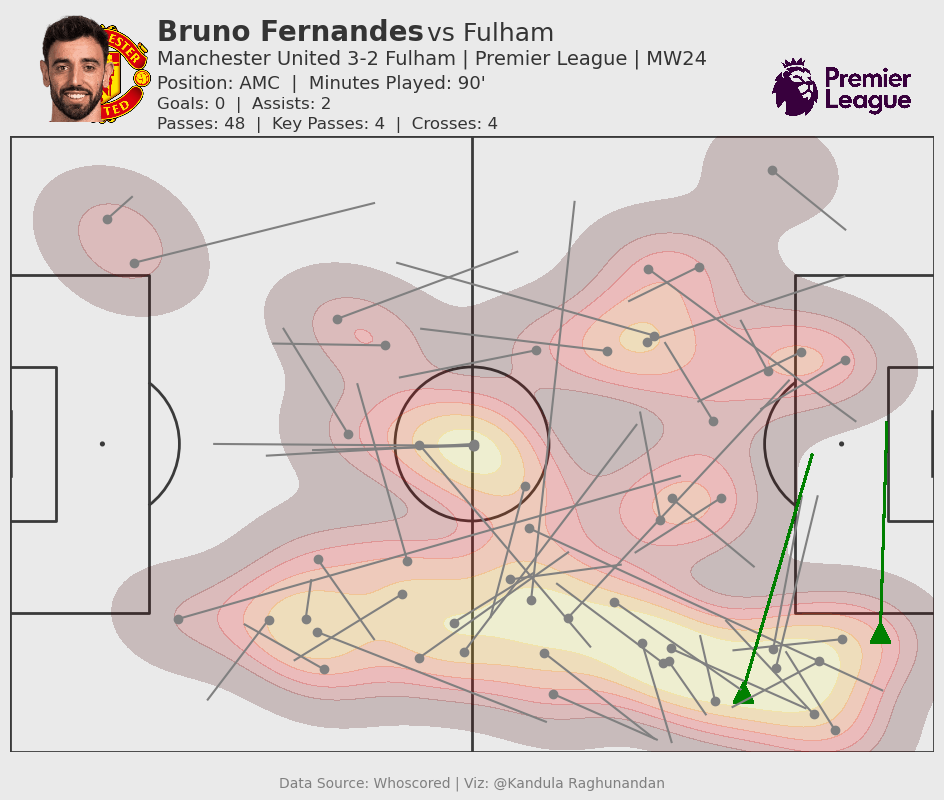

In [37]:
#Bruno Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_8, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Fernandes":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Fernandes") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][208]==True & df["isGoal"][1069]==True):
        plt.scatter(df["x"][207],df["y"][207],color="Green",marker="^",s=200)
        plt.scatter(df["x"][1068],df["y"][1068],color="Green",marker="^",s=200)
        plt.plot((df["x"][207],df["endX"][207]),(df["y"][207],df["endY"][207]),color="Green")
        plt.plot((df["x"][1068],df["endX"][1068]),(df["y"][1068],df["endY"][1068]),color="Green")
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Fernandes"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Bruno Fernandes", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.475,1,"vs Fulham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 3-2 Fulham | Premier League | MW24", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AMC  |  Minutes Played: 90'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Bruno Fernandes.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 2", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 48  |  Key Passes: 4  |  Crosses: 4", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 3-2 Fulham - Premier League 2025_2026 Live_files\New folder\Bruno.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\1634058842.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


43


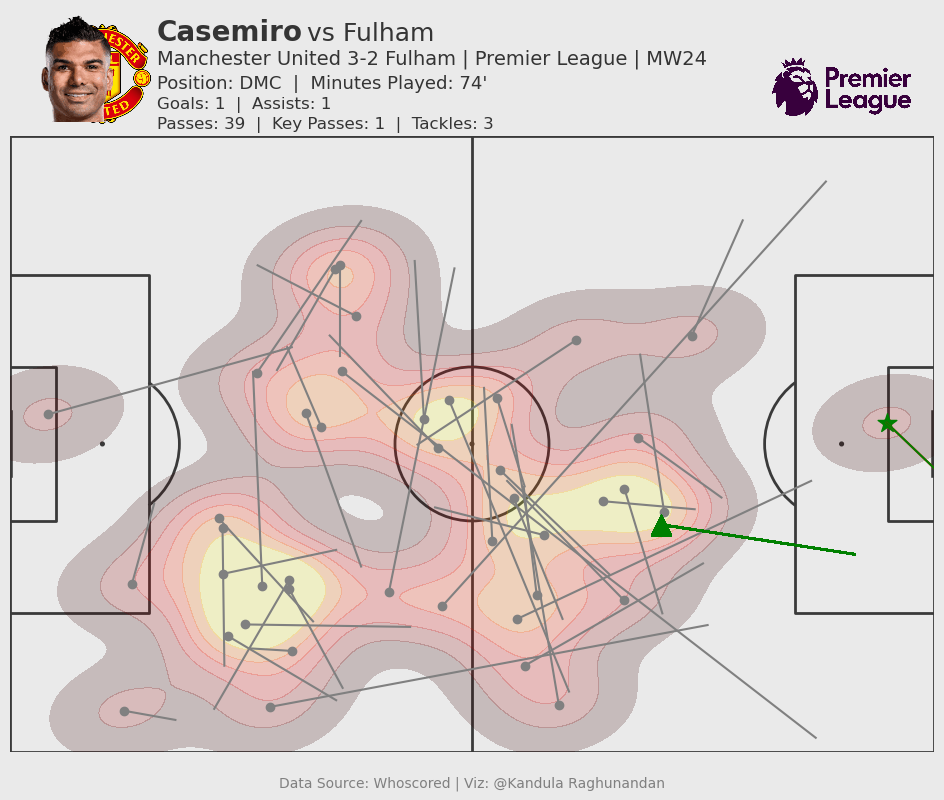

In [39]:
#Casemiro Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_18, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="Casemiro":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="Casemiro") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][692]==True):
        plt.scatter(df["x"][691],df["y"][691],color="Green",marker="^",s=200)
        plt.plot((df["x"][691],df["endX"][691]),(df["y"][691],df["endY"][691]),color="Green")
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="Casemiro"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Casemiro", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.375,1,"vs Fulham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 3-2 Fulham | Premier League | MW24", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DMC  |  Minutes Played: 74'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Casemiro.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 1", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 39  |  Key Passes: 1  |  Tackles: 3", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 3-2 Fulham - Premier League 2025_2026 Live_files\New folder\Casemiro.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\2494462996.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


52


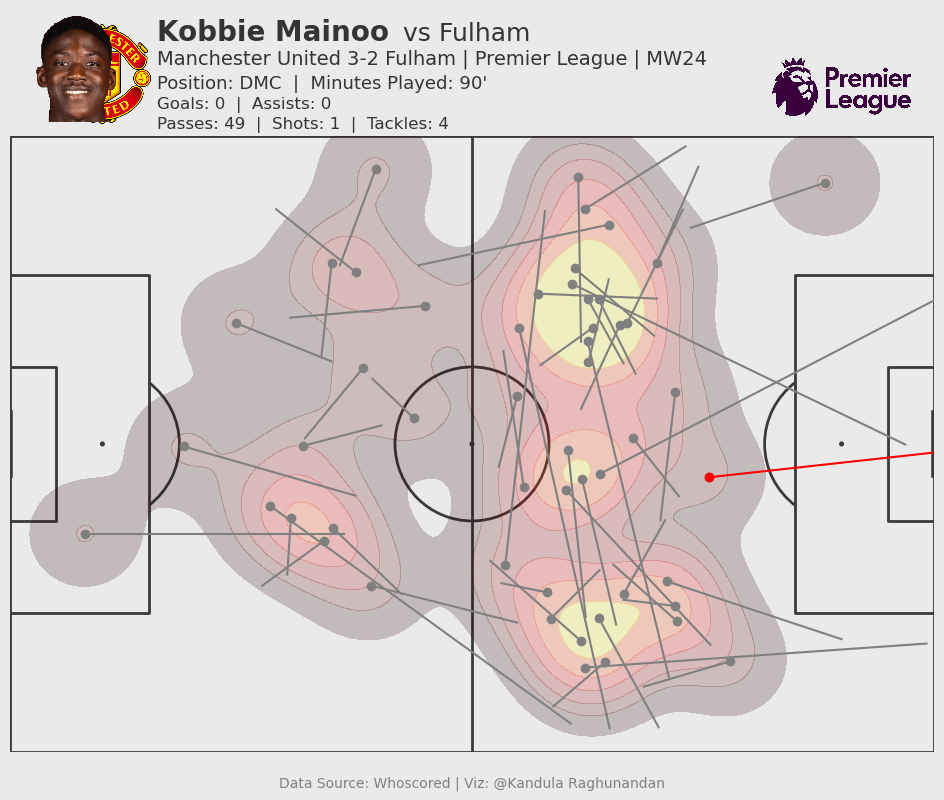

In [40]:
#Mainoo Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_37, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="K. Mainoo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="K. Mainoo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][863]==True):
        #plt.scatter(df["x"][862],df["y"][862],color="Green",marker="^",s=200)
        #plt.plot((df["x"][862],df["endX"][862]),(df["y"][862],df["endY"][862]),color="Green")
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="K. Mainoo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Kobbie Mainoo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.455,1,"vs Fulham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 3-2 Fulham | Premier League | MW24", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DMC  |  Minutes Played: 90'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Mainoo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 49  |  Shots: 1  |  Tackles: 4", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 3-2 Fulham - Premier League 2025_2026 Live_files\New folder\Mainoo.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\3053005931.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


23


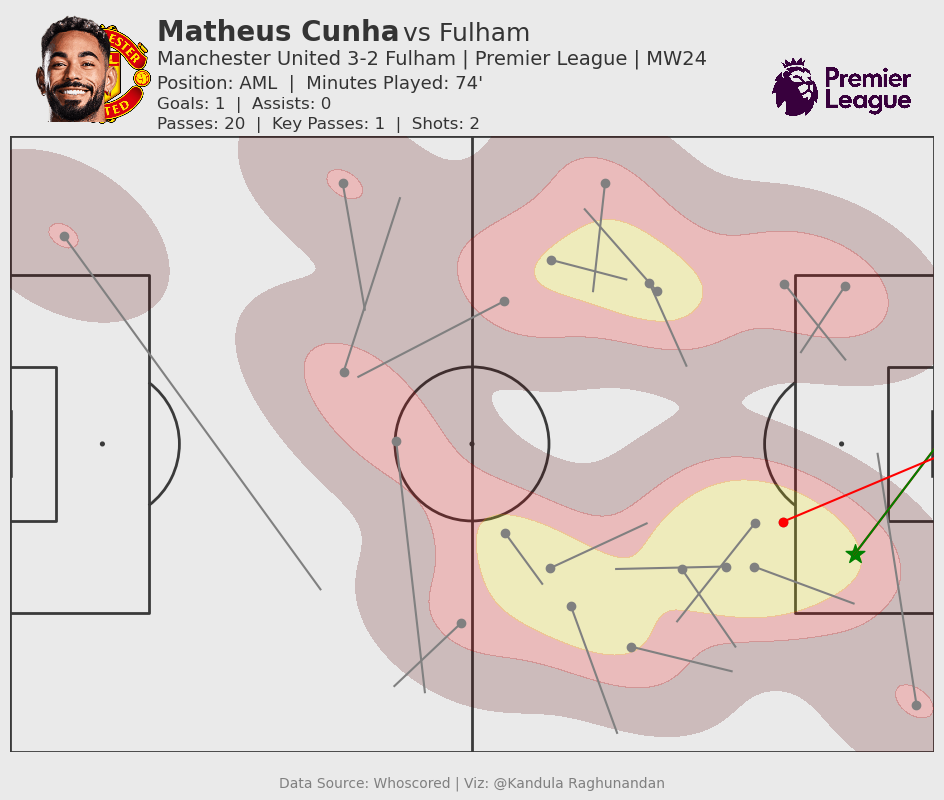

In [41]:
#Cunha Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_10, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=4,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="M. Cunha":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="M. Cunha") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][914]==True):
    #   plt.scatter(df["x"][913],df["y"][913],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="M. Cunha"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Matheus Cunha", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.455,1,"vs Fulham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 3-2 Fulham | Premier League | MW24", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AML  |  Minutes Played: 74'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Cunha.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 20  |  Key Passes: 1  |  Shots: 2", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 3-2 Fulham - Premier League 2025_2026 Live_files\New folder\Cunha.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\3367354221.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


8


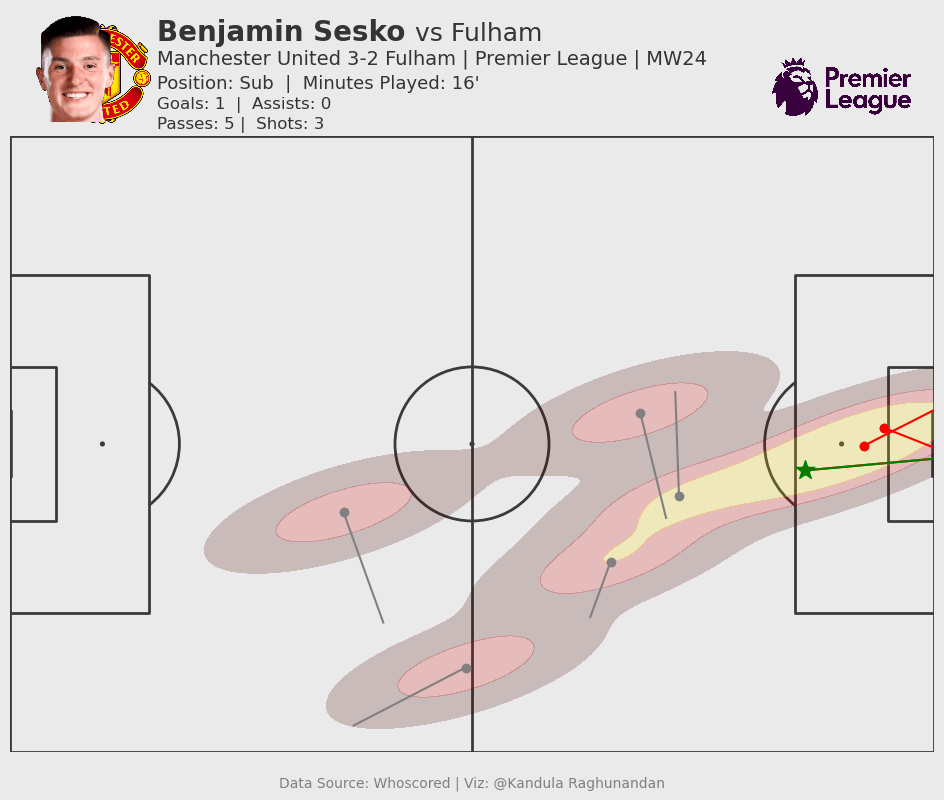

In [45]:
#Sesko Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_30, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=4,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Sesko":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Sesko") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][914]==True):
    #   plt.scatter(df["x"][913],df["y"][913],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Sesko"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Benjamin Sesko", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.465,1,"vs Fulham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 3-2 Fulham | Premier League | MW24", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: Sub  |  Minutes Played: 16'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Sesko.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 5 |  Shots: 3", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 3-2 Fulham - Premier League 2025_2026 Live_files\New folder\Sesko.jpg",bbox_inches='tight')

In [61]:
#Passing Networks Mun

In [47]:
df.columns

Index(['minute', 'second', 'x', 'y', 'endX', 'endY', 'teamName', 'shirtNo',
       'position', 'shortName', 'goalMouthY', 'isShot', 'isGoal'],
      dtype='object')

In [48]:
df_mun=df[df["teamName"]=="Man Utd"].reset_index()
df_mun

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,2,0,5.0,27.60,23.12,42.36,26.24,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
1,3,0,6.0,39.96,25.04,47.28,14.64,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
2,6,0,14.0,27.36,16.56,49.32,12.16,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN
3,7,0,16.0,55.44,9.04,39.84,15.60,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
4,8,0,17.0,39.84,15.60,69.60,3.92,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,1129,99,52.0,36.00,62.00,58.08,80.00,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN
494,1139,100,18.0,34.80,66.16,51.00,68.48,Man Utd,23.0,DL,L. Shaw,NaN,NaN,NaN
495,1143,101,3.0,5.16,46.96,42.36,52.32,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN
496,1148,101,17.0,10.08,68.80,49.08,80.00,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN


In [49]:
firstSub=74

In [50]:
df_mun=df_mun[df_mun["minute"]<firstSub]
df_mun

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,2,0,5.0,27.60,23.12,42.36,26.24,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
1,3,0,6.0,39.96,25.04,47.28,14.64,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
2,6,0,14.0,27.36,16.56,49.32,12.16,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN
3,7,0,16.0,55.44,9.04,39.84,15.60,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
4,8,0,17.0,39.84,15.60,69.60,3.92,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,847,72,34.0,52.92,29.52,79.08,16.80,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN
393,848,72,38.0,78.24,17.04,84.60,4.00,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
394,849,72,40.0,88.20,4.72,105.36,11.20,Man Utd,16.0,AMR,A. Diallo,NaN,NaN,NaN
395,850,72,43.0,107.64,11.28,100.44,29.92,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN


In [51]:
df_mun["passer"]=df_mun["shirtNo"]
df_mun["recipient"]=df_mun["shirtNo"].shift(-1)

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\1171812944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mun["passer"]=df_mun["shirtNo"]
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\1171812944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mun["recipient"]=df_mun["shirtNo"].shift(-1)


In [52]:
df_mun

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
0,2,0,5.0,27.60,23.12,42.36,26.24,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN,18.0,8.0
1,3,0,6.0,39.96,25.04,47.28,14.64,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN,8.0,5.0
2,6,0,14.0,27.36,16.56,49.32,12.16,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN,5.0,19.0
3,7,0,16.0,55.44,9.04,39.84,15.60,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN,19.0,8.0
4,8,0,17.0,39.84,15.60,69.60,3.92,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN,8.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,847,72,34.0,52.92,29.52,79.08,16.80,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN,5.0,2.0
393,848,72,38.0,78.24,17.04,84.60,4.00,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN,2.0,16.0
394,849,72,40.0,88.20,4.72,105.36,11.20,Man Utd,16.0,AMR,A. Diallo,NaN,NaN,NaN,16.0,2.0
395,850,72,43.0,107.64,11.28,100.44,29.92,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN,2.0,10.0


In [53]:
pas=pd.to_numeric(df_mun["passer"],downcast="integer")
rec=pd.to_numeric(df_mun["recipient"],downcast="integer")

df_mun["passer"]=pas
df_mun["recipient"]=rec

df_mun.head()

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\2514975927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mun["passer"]=pas
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\2514975927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mun["recipient"]=rec


,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
0,2,0,5.0,27.60,23.12,42.36,26.24,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN,18,8.0
1,3,0,6.0,39.96,25.04,47.28,14.64,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN,8,5.0
2,6,0,14.0,27.36,16.56,49.32,12.16,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN,5,19.0
3,7,0,16.0,55.44,9.04,39.84,15.60,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN,19,8.0
4,8,0,17.0,39.84,15.60,69.60,3.92,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN,8,16.0


In [54]:
df_mun=df_mun.drop(["goalMouthY","isShot","isGoal"],axis=1)

In [55]:
average_locations=df_mun.groupby("passer").agg({"x":["mean"],"y":["mean","count"]})
average_locations.columns=["x","y","count"]
average_locations.head()

,x,y,count
passer,,,
2,54.258947,15.788070,57
5,41.861538,30.518974,39
6,47.326829,54.466341,41
8,72.187692,30.629744,39
10,77.358261,40.612174,23


In [56]:
pass_between = (
    df_mun
    .groupby(["passer", "recipient"])
    .size()
    .reset_index(name="pass_count")
)

pass_between.head()

,passer,recipient,pass_count
0,2,5.0,10
1,2,6.0,3
2,2,8.0,4
3,2,10.0,5
4,2,16.0,11


In [57]:
pass_between = pass_between.merge(average_locations, left_on='passer', right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient', right_index=True, suffixes=['', '_end'])

pass_between.head()

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,2,5.0,10,54.258947,15.78807,57,41.861538,30.518974,39
1,2,6.0,3,54.258947,15.78807,57,47.326829,54.466341,41
2,2,8.0,4,54.258947,15.78807,57,72.187692,30.629744,39
3,2,10.0,5,54.258947,15.78807,57,77.358261,40.612174,23
4,2,16.0,11,54.258947,15.78807,57,71.314737,12.553684,38


In [58]:
pass_between=pass_between[pass_between["pass_count"]>3]
pass_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,2,5.0,10,54.258947,15.788070,57,41.861538,30.518974,39
2,2,8.0,4,54.258947,15.788070,57,72.187692,30.629744,39
3,2,10.0,5,54.258947,15.788070,57,77.358261,40.612174,23
4,2,16.0,11,54.258947,15.788070,57,71.314737,12.553684,38
5,2,18.0,8,54.258947,15.788070,57,52.746977,31.841860,43
6,2,19.0,6,54.258947,15.788070,57,81.584348,30.295652,23
8,2,31.0,5,54.258947,15.788070,57,12.225600,41.017600,25
9,2,37.0,4,54.258947,15.788070,57,63.812308,43.216410,39
10,5,2.0,13,41.861538,30.518974,39,54.258947,15.788070,57
11,5,6.0,7,41.861538,30.518974,39,47.326829,54.466341,41


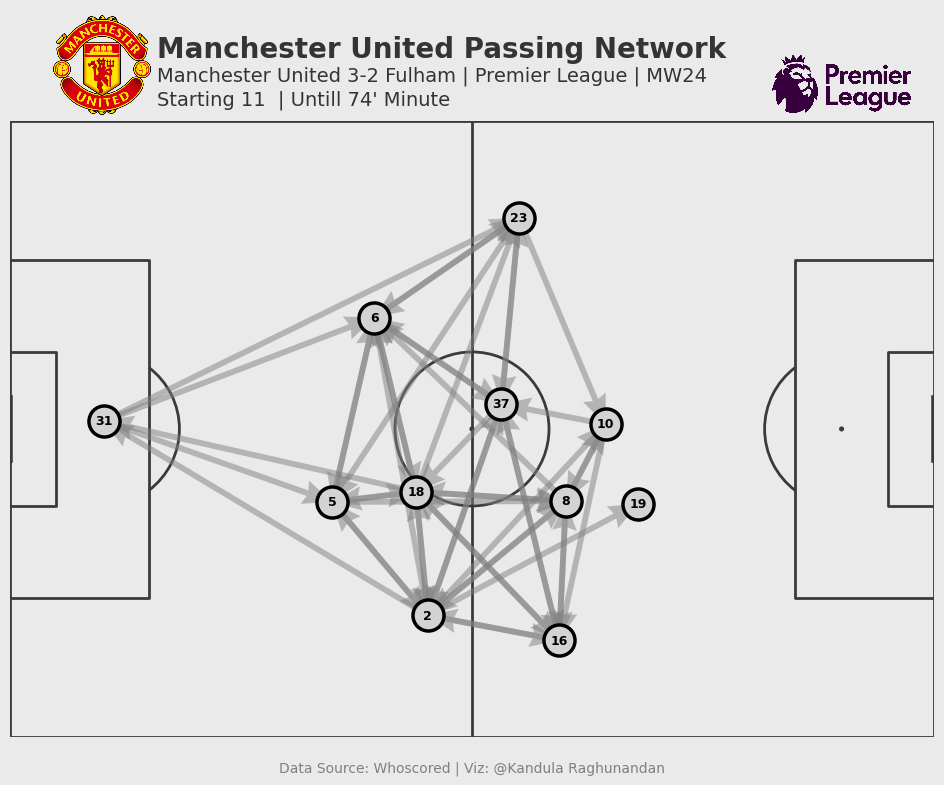

In [60]:
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

arrows=pitch.arrows(pass_between.x,
                    pass_between.y,
                    pass_between.x_end,
                    pass_between.y_end,
                    ax=ax,
                    width=4.2,
                    headwidth=4.2,
                    color="#808080",
                    alpha=.5)

nodes=pitch.scatter(average_locations.x,
                    average_locations.y,
                    s=500,
                    color="#d3d3d3",
                    edgecolor="black",
                    linewidth=2.5,
                    alpha=1,
                    ax=ax)

for passer, row in average_locations.iterrows():
    ax.text(
        row['x'],    # x position
        row['y'],    # y position
        str(passer),       # the index (playerId)
        ha='center', va='center',
        fontsize=9, color='black', weight='bold'
    )

fig.text(0.25, 0.96, "Manchester United Passing Network", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.25, 0.93, "Manchester United 3-2 Fulham | Premier League | MW24",fontsize=14, color='#343434')
fig.text(0.25, 0.90, "Starting 11  | Untill 74' Minute",fontsize=14, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.09))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.06))

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 3-2 Fulham - Premier League 2025_2026 Live_files\New folder\pass_net.jpg",bbox_inches='tight')

In [62]:
#Passing Network Ful

In [63]:
df_ful=df[df["teamName"]=="Fulham"].reset_index()
df_ful

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0,0.0,60.00,40.00,37.68,37.12,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN
1,1,0,4.0,42.12,38.56,86.76,56.40,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN
2,4,0,9.0,72.84,59.36,53.64,66.64,Fulham,16.0,DMC,S. Berge,NaN,NaN,NaN
3,5,0,13.0,56.04,73.12,88.20,66.08,Fulham,15.0,DC,J. Cuenca,NaN,NaN,NaN
4,24,1,21.0,16.08,44.88,32.52,62.80,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,1149,101,33.0,78.72,0.00,70.92,3.92,Fulham,8.0,AMR,H. Wilson,NaN,NaN,NaN
653,1150,101,36.0,71.04,3.92,73.56,13.44,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN
654,1151,101,38.0,75.24,13.36,69.60,7.04,Fulham,10.0,Sub,T. Cairney,NaN,NaN,NaN
655,1152,101,39.0,66.96,6.08,39.36,24.48,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN


In [64]:
firstSub=71

In [65]:
df_ful=df_ful[df_ful["minute"]<firstSub]
df_ful

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0,0.0,60.00,40.00,37.68,37.12,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN
1,1,0,4.0,42.12,38.56,86.76,56.40,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN
2,4,0,9.0,72.84,59.36,53.64,66.64,Fulham,16.0,DMC,S. Berge,NaN,NaN,NaN
3,5,0,13.0,56.04,73.12,88.20,66.08,Fulham,15.0,DC,J. Cuenca,NaN,NaN,NaN
4,24,1,21.0,16.08,44.88,32.52,62.80,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,814,69,37.0,83.88,68.08,72.48,67.76,Fulham,32.0,AMC,E. S. Rowe,NaN,NaN,NaN
449,815,69,38.0,72.48,67.76,81.60,76.24,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN
450,816,69,43.0,92.76,60.08,99.96,74.40,Fulham,33.0,DL,A. Robinson,NaN,NaN,NaN
451,817,69,45.0,100.08,74.88,113.04,67.04,Fulham,32.0,AMC,E. S. Rowe,NaN,NaN,NaN


In [66]:
df_ful["passer"]=df_ful["shirtNo"]
df_ful["recipient"]=df_ful["shirtNo"].shift(-1)

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\2383368556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ful["passer"]=df_ful["shirtNo"]
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\2383368556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ful["recipient"]=df_ful["shirtNo"].shift(-1)


In [67]:
df_ful

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
0,0,0,0.0,60.00,40.00,37.68,37.12,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN,17.0,5.0
1,1,0,4.0,42.12,38.56,86.76,56.40,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN,5.0,16.0
2,4,0,9.0,72.84,59.36,53.64,66.64,Fulham,16.0,DMC,S. Berge,NaN,NaN,NaN,16.0,15.0
3,5,0,13.0,56.04,73.12,88.20,66.08,Fulham,15.0,DC,J. Cuenca,NaN,NaN,NaN,15.0,17.0
4,24,1,21.0,16.08,44.88,32.52,62.80,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN,17.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,814,69,37.0,83.88,68.08,72.48,67.76,Fulham,32.0,AMC,E. S. Rowe,NaN,NaN,NaN,32.0,17.0
449,815,69,38.0,72.48,67.76,81.60,76.24,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN,17.0,33.0
450,816,69,43.0,92.76,60.08,99.96,74.40,Fulham,33.0,DL,A. Robinson,NaN,NaN,NaN,33.0,32.0
451,817,69,45.0,100.08,74.88,113.04,67.04,Fulham,32.0,AMC,E. S. Rowe,NaN,NaN,NaN,32.0,33.0


In [69]:
pas=pd.to_numeric(df_ful["passer"],downcast="integer")
rec=pd.to_numeric(df_ful["recipient"],downcast="integer")

df_ful["passer"]=pas
df_ful["recipient"]=rec

df_ful.head()

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\2113768436.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ful["passer"]=pas
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21836\2113768436.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ful["recipient"]=rec


,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
0,0,0,0.0,60.00,40.00,37.68,37.12,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN,17,5.0
1,1,0,4.0,42.12,38.56,86.76,56.40,Fulham,5.0,DC,J. Andersen,NaN,NaN,NaN,5,16.0
2,4,0,9.0,72.84,59.36,53.64,66.64,Fulham,16.0,DMC,S. Berge,NaN,NaN,NaN,16,15.0
3,5,0,13.0,56.04,73.12,88.20,66.08,Fulham,15.0,DC,J. Cuenca,NaN,NaN,NaN,15,17.0
4,24,1,21.0,16.08,44.88,32.52,62.80,Fulham,17.0,DMC,A. Iwobi,NaN,NaN,NaN,17,21.0


In [70]:
df_ful=df_ful.drop(["goalMouthY","isShot","isGoal"],axis=1)

In [71]:
average_locations=df_ful.groupby("passer").agg({"x":["mean"],"y":["mean","count"]})
average_locations.columns=["x","y","count"]
average_locations.head()

,x,y,count
passer,,,
1,15.137778,39.057778,27
5,48.581538,24.304615,52
7,63.644211,36.749474,19
8,71.616000,22.444800,25
15,38.574915,52.992542,59


In [72]:
pass_between = (
    df_ful
    .groupby(["passer", "recipient"])
    .size()
    .reset_index(name="pass_count")
)

pass_between.head()

,passer,recipient,pass_count
0,1,5.0,2
1,1,7.0,1
2,1,15.0,17
3,1,16.0,1
4,1,17.0,1


In [73]:
pass_between = pass_between.merge(average_locations, left_on='passer', right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient', right_index=True, suffixes=['', '_end'])

pass_between.head()

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,1,5.0,2,15.137778,39.057778,27,48.581538,24.304615,52
1,1,7.0,1,15.137778,39.057778,27,63.644211,36.749474,19
2,1,15.0,17,15.137778,39.057778,27,38.574915,52.992542,59
3,1,16.0,1,15.137778,39.057778,27,58.804615,41.821538,52
4,1,17.0,1,15.137778,39.057778,27,64.620000,41.124706,68


In [74]:
pass_between=pass_between[pass_between["pass_count"]>3]
pass_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
2,1,15.0,17,15.137778,39.057778,27,38.574915,52.992542,59
7,5,1.0,5,48.581538,24.304615,52,15.137778,39.057778,27
10,5,8.0,4,48.581538,24.304615,52,71.616000,22.444800,25
11,5,15.0,7,48.581538,24.304615,52,38.574915,52.992542,59
12,5,16.0,10,48.581538,24.304615,52,58.804615,41.821538,52
13,5,17.0,5,48.581538,24.304615,52,64.620000,41.124706,68
15,5,21.0,12,48.581538,24.304615,52,61.124651,12.111628,43
26,7,21.0,4,63.644211,36.749474,19,61.124651,12.111628,43
34,8,17.0,4,71.616000,22.444800,25,64.620000,41.124706,68
36,8,21.0,6,71.616000,22.444800,25,61.124651,12.111628,43


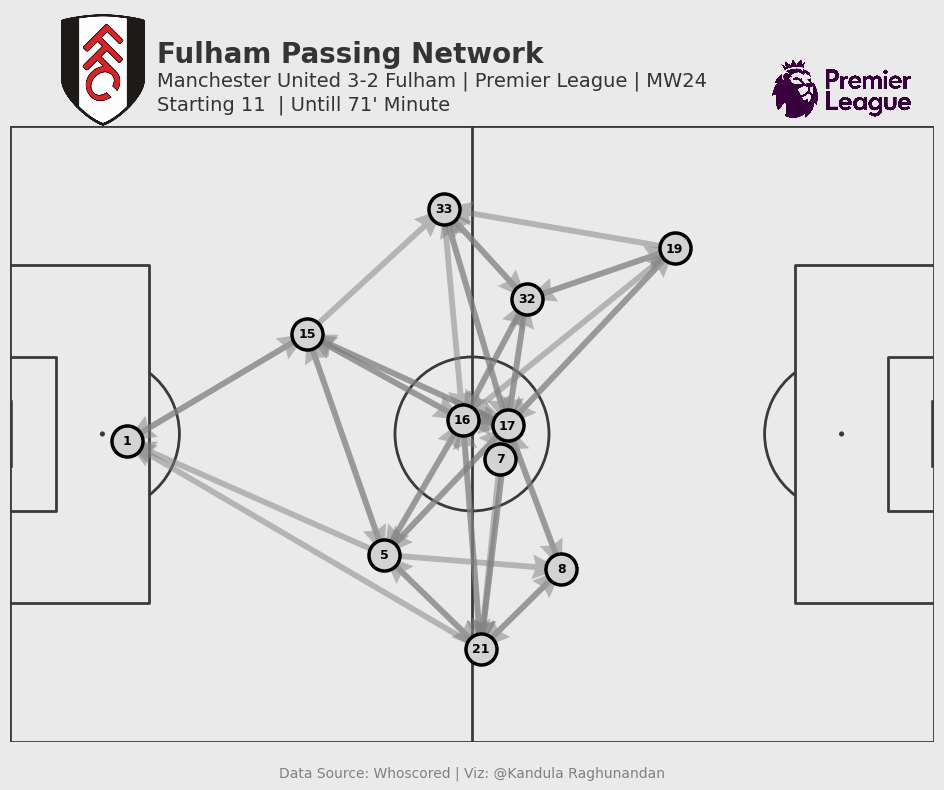

In [76]:
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

arrows=pitch.arrows(pass_between.x,
                    pass_between.y,
                    pass_between.x_end,
                    pass_between.y_end,
                    ax=ax,
                    width=4.2,
                    headwidth=4.2,
                    color="#808080",
                    alpha=.5)

nodes=pitch.scatter(average_locations.x,
                    average_locations.y,
                    s=500,
                    color="#d3d3d3",
                    edgecolor="black",
                    linewidth=2.5,
                    alpha=1,
                    ax=ax)

for passer, row in average_locations.iterrows():
    ax.text(
        row['x'],    # x position
        row['y'],    # y position
        str(passer),       # the index (playerId)
        ha='center', va='center',
        fontsize=9, color='black', weight='bold'
    )

fig.text(0.25, 0.96, "Fulham Passing Network", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.25, 0.93, "Manchester United 3-2 Fulham | Premier League | MW24",fontsize=14, color='#343434')
fig.text(0.25, 0.90, "Starting 11  | Untill 71' Minute",fontsize=14, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Fulham.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.09))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.06))

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 3-2 Fulham - Premier League 2025_2026 Live_files\New folder\pass_net_ful.jpg",bbox_inches='tight')